# Cleaning TRACE Corporate Bond Data: A Walkthrough

This notebook walks through an end-to-end pipeline for cleaning FINRA TRACE
corporate bond transaction data. We start from raw intraday trade reports and
progress through filtering, error correction, and daily aggregation to produce
an enriched panel with duration, convexity, and credit spreads.

We use a **January--February 2024** sample window throughout. The same
pipeline runs identically on the full 2002--present history.

In [1]:
import os
import sys
from pathlib import Path

# Ensure src/ is importable regardless of where the notebook executes from.
# When run via dodo.py the cwd is the project root; when run from _output/
# we walk up to find the src/ directory.
_cwd = Path.cwd()
_candidates = [_cwd / "src", _cwd.parent / "src", _cwd]
for _p in _candidates:
    if (_p / "settings.py").exists():
        sys.path.insert(0, str(_p))
        os.chdir(_p.parent)  # set project root as cwd
        break

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import polars as pl

from settings import config

DATA_DIR = Path(config("DATA_DIR"))
PULL_DIR = DATA_DIR / "pulled"

plt.rcParams.update({
    "figure.figsize": (10, 4),
    "axes.titlesize": 13,
    "axes.labelsize": 11,
    "figure.dpi": 120,
})

---
## 1. What Is TRACE and Why Does Cleaning Matter?

**TRACE** (Trade Reporting and Compliance Engine) is operated by FINRA. Every
over-the-counter (OTC) corporate bond trade in the United States must be
reported to TRACE within 15 minutes of execution. TRACE Enhanced, available
from July 2002, provides the most complete data: counterparty identifiers,
the full trade lifecycle (original reports, corrections, cancellations,
reversals), and both price and volume.

### What securities does TRACE cover?

While this project focuses on corporate bonds, TRACE covers several
categories of fixed-income securities:

- **Corporate bonds** (investment-grade, high-yield, and convertible
  debt)---reported since TRACE launched in **July 2002**. This is the
  asset class we work with here.
- **Agency debentures**---reported since **March 2010**.
- **Mortgage-backed securities (MBS) and asset-backed securities (ABS)**,
  including TBA transactions---reported since **May 2011**; public
  dissemination was phased in through 2015.
- **U.S. Treasury securities**---reported since **July 2017**, but
  transaction-level public dissemination only began in March 2024,
  limited to on-the-run nominal coupons on an end-of-day basis. Full
  Treasury transaction data is not available to the public or
  researchers.
- **Rule 144A private placements**---reported separately; included in
  our pipeline via the TRACE 144A feed.

### What information is in the public data?

The corporate bond transaction data that FINRA makes available to the
public and to academics includes trade-level details (price, yield,
volume, execution time, buy/sell indicator, counterparty type), but
**dealer identity is either removed or masked**. The TRACE Enhanced
data available on WRDS does not contain unmasked dealer identifiers.

### Data access

- **WRDS** is the most common academic access point for corporate bond
  TRACE data (Enhanced, Standard, and 144A feeds). WRDS does not host
  agency, MBS/ABS, or Treasury TRACE data.
- **FINRA** also makes corporate bond TRACE data available directly to
  academic institutions and to the public (with delays). MBS/ABS
  historical data requires a separate agreement with FINRA. Free
  next-day transaction data and aggregate reports are available on
  [FINRA's website](https://www.finra.org/finra-data/fixed-income)
  for non-commercial use.

Unlike equities, which trade on centralized exchanges with a consolidated
limit order book, corporate bonds trade OTC through dealer intermediaries.
This creates fundamental data-quality challenges:

- **No consolidated best bid/offer.** Prices reflect individually negotiated
  trades between dealers and customers or between dealers.
- **Market microstructure noise (MMN)** is substantially larger than in
  equities. Transaction prices contain bid-ask bounce and dealer markups.
- **Trade lifecycle records.** A single economic trade can generate multiple
  TRACE records (original report, cancellation, correction, reversal).

Using uncleaned TRACE data leads to **biased return estimates** and
**spurious factor premia**---a problem documented extensively in recent
research.

### Why this pipeline exists: lessons from the literature

**Dickerson, Robotti, and Rossetti (2024), "Common pitfalls in the evaluation
of corporate bond strategies"** (SSRN 4575879):

- Large abnormal returns documented for many corporate bond strategies are
  primarily artifacts of (a) ignoring market microstructure noise in
  transaction-based prices and (b) applying ex-post (asymmetric) data
  filtering.
- **MMN magnitude:** The short-term reversal premium drops from **0.90% per
  month to approximately zero** after correcting for MMN. Price-based signals
  (credit spread, yield) show **50--65% reductions** in return premiums.
- **Ex-post filtering bias:** Out of 480 ex-ante filtered strategies, only
  2 (0.4%) produce significant momentum premia. With ex-post filtering, that
  number jumps to 119 (25%)---almost entirely an artifact.
- **Recommendation:** Use an "implementation gap" (source signal prices at
  least one day before month-end execution prices) and apply only ex-ante
  filters with information available at portfolio formation.

**Dickerson, Robotti, and Rossetti (2026), "The Corporate Bond Factor
Replication Crisis":**

- Evaluates **108 signals across 9 thematic clusters** using the Open Bond
  Asset Pricing (OBAP) framework.
- Two sources systematically inflate reported premia: (a) OTC
  microstructure that prevents execution at signal-formation prices, and
  (b) ex-post filtering that embeds future information into portfolio
  construction.
- **Result:** The majority of previously documented anomalies fail---they
  are artifacts of measurement error, not genuine risk premia.
- Provides an **open-source end-to-end TRACE data pipeline** (the basis
  for the Stage 0 cleaning code in this project).

### Pipeline overview

```
Raw TRACE Enhanced   --[FISD filter]-->   FISD-filtered   --[11 filters + daily agg]-->   Stage 0
  (intraday trades)                       (standard US                                     (daily panel)
                                           corporate bonds)                                    |
                                                                                               v
                                                             Stage 1  <--[QuantLib + ratings + linker]
                                                        (enriched panel: duration, convexity,
                                                         credit spreads, ratings, equity IDs)
```

---
## 2. Data Sources and Pipeline Overview

The pipeline consumes **14 datasets** from four providers: WRDS (TRACE
trade feeds and FISD bond reference tables), the Liu-Wu yield curve
(Google Sheets), the Kenneth French Data Library (Dartmouth), and the
Open Source Bond Asset Pricing project
([openbondassetpricing.com](https://openbondassetpricing.com)). These
fall into three groups: **trade data** (the raw transactions we clean),
**bond reference data** (characteristics, ratings, and identifiers we
merge in), and **validation / linkage data** (external benchmarks and
cross-asset links).

| # | Dataset | Source | Pipeline role | Stage |
|---|---------|--------|---------------|-------|
| 1 | TRACE Enhanced | WRDS | Primary trade data (Jul 2002--Sep 2024) | Pull $\to$ FISD filter $\to$ Stage 0 $\to$ Stage 1 |
| 2 | TRACE Standard | WRDS | Extends trade coverage (Oct 2024+) | Pull $\to$ FISD filter $\to$ Stage 0 $\to$ Stage 1 |
| 3 | TRACE 144A | WRDS | Private-placement trades (Rule 144A) | Pull $\to$ FISD filter $\to$ Stage 0 $\to$ Stage 1 |
| 4 | FISD Issue | WRDS | Bond-level reference (coupon, maturity, offering) | Pre-processing + Stage 1 |
| 5 | FISD Issuer | WRDS | Issuer attributes (SIC code, country) | Pre-processing |
| 6 | FISD Amount Outstanding | WRDS | Time-varying par amount outstanding | Stage 1 |
| 7 | FISD Ratings (S&P) | WRDS | Historical S&P credit ratings | Stage 1 |
| 8 | FISD Ratings (Moody's) | WRDS | Historical Moody's credit ratings | Stage 1 |
| 9 | FISD Redemption | WRDS | Callable-bond flag | Stage 1 |
| 10 | Liu-Wu Treasury Yields | Google Sheets | Zero-coupon yield curve for credit spreads | Stage 1 |
| 11 | Fama-French SIC Codes | Dartmouth | Industry classification (FF-17 / FF-30) | Stage 1 |
| 12 | OSBAP Linker (Fang, 2025) | OSBAP | Bond-to-equity identifier mapping | Stage 1 |
| 13 | OSBAP Corporate Bond Returns | OSBAP | Validation benchmark (duration, spreads) | Testing only |
| 14 | OSBAP Treasury Bond Returns | OSBAP | Not currently consumed | --- |

### Three TRACE feeds

FINRA publishes corporate bond trades through three separate reporting
channels. The pipeline pulls all three and merges them after cleaning:

- **Enhanced** is the workhorse dataset. It has the longest history
  (July 2002 onward), the richest columns (exact volume in
  `entrd_vol_qt`, counterparty IDs in `cntra_mp_id`), and is the
  target of most academic TRACE-cleaning papers.
- **Standard** is the real-time public feed. WRDS makes it available
  from October 2024, so it extends coverage into months where Enhanced
  is not yet released. It uses a slightly different column schema
  (`ascii_rptd_vol_tx` for volume, `side` instead of `rpt_side_cd`).
- **144A** captures a separate market segment: bonds sold to qualified
  institutional buyers under SEC Rule 144A. These private placements
  do not appear in the Enhanced or Standard feeds.

When the three are combined in Stage 1, **Enhanced takes priority**.
Standard is clipped to dates *after* the Enhanced maximum date to
avoid overlap, while 144A rows are kept unconditionally (they cover
distinct bonds). Duplicate (cusip, date) pairs across feeds are
resolved with preference Enhanced > Standard > 144A.

### FISD reference data (6 files)

The Mergent Fixed Income Securities Database (FISD), accessed via WRDS,
provides the bond-level reference data that the pipeline relies on
throughout:

- **FISD Issue** --- One row per bond. Coupon, maturity, offering date,
  offering amount, bond type, currency, and other characteristics.
  Combined with FISD Issuer to build the **FISD universe** of standard
  US corporate bonds (10 screens: USD only, fixed-rate, non-convertible,
  non-ABS, etc.). Also used in Stage 1 to map `issue_id` to CUSIP for
  ratings and amount-outstanding merges.
- **FISD Issuer** --- One row per issuer. Provides the SIC code (used
  for Fama-French industry classification) and country of domicile.
- **FISD Amount Outstanding History** --- Time-varying par amount.
  Merged into the Stage 1 panel via `merge_asof` (backward on date) so
  each bond-day observation reflects the most recent outstanding amount.
- **FISD Ratings (S&P)** and **FISD Ratings (Moody's)** --- Historical
  credit ratings (one row per rating event). Converted to numeric
  scales in Stage 1 and merged via `merge_asof` so each bond-day gets
  the most recent rating. A composite rating is computed as the average
  of the S&P and Moody's numeric scores.
- **FISD Redemption** --- Callable/redeemable flags. Produces a binary
  `callable` indicator merged into Stage 1.

### Liu-Wu Treasury yields

The Liu-Wu zero-coupon Treasury yield curve (sourced from a Google
Sheets mirror of the original Liu-Wu dataset) provides daily yields
at 1, 2, 5, 7, 10, 20, and 30-year maturities. Stage 1 interpolates
this curve at each bond's remaining maturity and subtracts the
duration-matched Treasury yield from the bond's yield-to-maturity to
compute the **credit spread**.

### Fama-French SIC codes

The Kenneth French Data Library provides mappings from SIC code ranges
to the Fama-French 17-industry and 30-industry classification systems.
In Stage 1, each bond issuer's SIC code (from FISD Issuer) is matched
to these ranges, adding `ff17num` and `ff30num` industry identifiers
to every bond-day observation.

### Open Source Bond Asset Pricing (OSBAP) datasets

The OSBAP project at
[openbondassetpricing.com](https://openbondassetpricing.com) provides
three files that play different roles:

- **OSBAP Linker (Fang, 2025)** --- A core Stage 1 input. Maps issuer
  CUSIPs (first 6 characters) to equity identifiers (PERMNO, PERMCO,
  GVKEY) over time. Many bonds are issued through subsidiaries that do
  not share the parent's identifiers, and 19% of CUSIP-6s change
  ultimate parents during the sample. The linker resolves this using
  CUSIP-ticker mappings from ICE and TRACE, the ticker-GVKEY mapping
  from Compustat, and the CRSP-Compustat link, with extensive hand
  corrections. Forward-filled and left-joined on (issuer CUSIP,
  year-month) in Stage 1 Step 7.
- **OSBAP Corporate Bond Returns** --- A **validation-only** benchmark.
  The test suite (`test_stage1_vs_open_source.py`) aggregates Stage 1
  daily output to month-end, inner-joins with OSBAP on (cusip, date),
  and checks that yield-to-maturity, modified duration, convexity,
  credit spread, time-to-maturity, bond market cap, bond age, and
  industry classifications are highly correlated and within acceptable
  tolerance. This is how we confirm the pipeline is producing
  correct results.
- **OSBAP Treasury Bond Returns** --- Pulled for completeness but not
  currently consumed by any processing or validation stage.

---
## 3. Raw TRACE Enhanced Data

Each row in raw TRACE is a **single trade report**. Key columns:

| Column | Description |
|---|---|
| `cusip_id` | 9-character bond identifier |
| `trd_exctn_dt` / `trd_exctn_tm` | Execution date and time |
| `rptd_pr` | Reported price per $100 par |
| `entrd_vol_qt` | Par volume traded |
| `yld_pt` | Yield at time of trade |
| `trc_st` | Status code: **T** = original trade, **X** = cancellation, **C** = correction, **W**/**Y** = reversal |
| `rpt_side_cd` | **B** = buy, **S** = sell (from reporting dealer perspective) |
| `cntra_mp_id` | Counterparty: **C** = customer, **D** = inter-dealer |
| `msg_seq_nb` / `orig_msg_seq_nb` | Sequence numbers for matching corrections to originals |

In [2]:
raw = pl.scan_parquet(
    PULL_DIR / "trace_enhanced" / "**/*.parquet",
    hive_partitioning=True,
    missing_columns="insert",
).filter(pl.col("year") == 2024, pl.col("month") == 1)

n_raw = raw.select(pl.len()).collect().item()
cols_raw = raw.collect_schema().names()
print(f"Raw TRACE Enhanced (Jan 2024) -- Rows: {n_raw:,}  |  Columns: {len(cols_raw)}")

Raw TRACE Enhanced (Jan 2024) -- Rows: 3,768,457  |  Columns: 21


### Example rows

In [3]:
raw.head(10).collect()

cusip_id,bond_sym_id,trd_exctn_dt,trd_exctn_tm,days_to_sttl_ct,lckd_in_ind,wis_fl,sale_cndtn_cd,msg_seq_nb,trc_st,trd_rpt_dt,trd_rpt_tm,entrd_vol_qt,rptd_pr,yld_pt,asof_cd,orig_msg_seq_nb,rpt_side_cd,cntra_mp_id,year,month
str,str,date,i64,str,str,str,str,str,str,date,i64,f64,f64,f64,str,str,str,str,i64,i64
"""02209SBD4""","""MO4797929""",2024-01-01,78261000000000,null,null,"""N""",null,"""0000453""","""T""",2024-01-02,28812000000000,3000.0,100.049,4.787982,"""A""",null,"""B""","""D""",2024,1
"""02209SBD4""","""MO4797929""",2024-01-01,78261000000000,null,null,"""N""",null,"""0000555""","""T""",2024-01-02,28813000000000,3000.0,100.049,4.787982,"""A""",null,"""S""","""D""",2024,1
"""254687FS0""","""DIS4969022""",2024-01-01,81521000000000,null,null,"""N""",null,"""0000479""","""T""",2024-01-02,28812000000000,5000.0,97.448,4.872966,"""A""",null,"""B""","""D""",2024,1
"""254687FS0""","""DIS4969022""",2024-01-01,81521000000000,null,null,"""N""",null,"""0000547""","""T""",2024-01-02,28813000000000,5000.0,97.448,4.872966,"""A""",null,"""S""","""D""",2024,1
"""30303M8J4""","""FB5522214""",2024-01-01,81331000000000,null,null,"""N""",null,"""0000474""","""T""",2024-01-02,28812000000000,10000.0,92.531,4.940009,"""A""",null,"""B""","""D""",2024,1
"""30303M8J4""","""FB5522214""",2024-01-01,81331000000000,null,null,"""N""",null,"""0000558""","""T""",2024-01-02,28813000000000,10000.0,92.531,4.940009,"""A""",null,"""S""","""D""",2024,1
"""404280DH9""","""HBC5458071""",2024-01-01,81225000000000,null,null,"""N""",null,"""0000072""","""T""",2024-01-02,28807000000000,2e6,101.0,null,"""A""",null,"""S""","""A""",2024,1
"""458140BX7""","""INTC5238071""",2024-01-01,81367000000000,null,null,"""N""",null,"""0000477""","""T""",2024-01-02,28812000000000,10000.0,69.707,4.993,"""A""",null,"""B""","""D""",2024,1
"""458140BX7""","""INTC5238071""",2024-01-01,81367000000000,null,null,"""N""",null,"""0000566""","""T""",2024-01-02,28813000000000,10000.0,69.707,4.993,"""A""",null,"""S""","""D""",2024,1


In [4]:
raw.tail(10).collect().glimpse()

Rows: 10
Columns: 21
$ cusip_id         <str> 'Y8085FBU3', 'Y8085FBU3', 'Y8085FBU3', 'Y8846QAG1', 'Y8846QAG1', 'Y8846QAG1', 'Y8846QAG1', 'Y8850AAB0', 'Y93541AA1', 'Y93541AA1'
$ bond_sym_id      <str> 'HXSCF5730863', 'HXSCF5730863', 'HXSCF5730863', 'PTFRF4937561', 'PTFRF4937561', 'PTFRF4937561', 'PTFRF4937561', 'TNABY4760205', 'CHVKF4590832', 'CHVKF4590832'
$ trd_exctn_dt    <date> 2024-01-31, 2024-01-31, 2024-01-31, 2024-01-31, 2024-01-31, 2024-01-31, 2024-01-31, 2024-01-31, 2024-01-31, 2024-01-31
$ trd_exctn_tm     <i64> 36763000000000, 36763000000000, 42120000000000, 6279000000000, 6279000000000, 8933000000000, 30235000000000, 42808000000000, 16600000000000, 16600000000000
$ days_to_sttl_ct  <str> null, null, null, null, null, null, null, null, null, null
$ lckd_in_ind      <str> null, null, null, null, null, null, null, null, null, null
$ wis_fl           <str> 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N'
$ sale_cndtn_cd    <str> null, null, null, null, null, null, null, null, n

### TRACE status code distribution

The `trc_st` column tells us whether a record is an original trade (**T**),
a cancellation (**X**), a correction (**C**), or a reversal (**W**/**Y**).
Only status-T records represent actual trades. The rest are amendments to
prior records and must be matched and handled by the Dick-Nielsen cleaning
procedure.

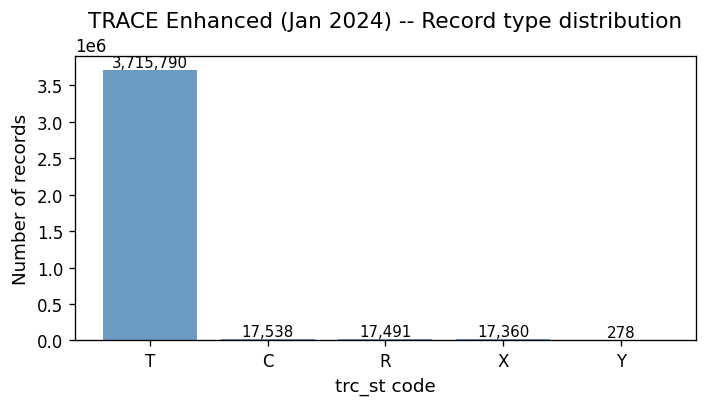

In [5]:
trc_st_dist = (
    raw.group_by("trc_st")
    .agg(pl.len().alias("n"))
    .sort("n", descending=True)
    .collect()
)

fig, ax = plt.subplots(figsize=(6, 3.5))
bars = ax.bar(
    trc_st_dist["trc_st"].to_list(),
    trc_st_dist["n"].to_list(),
    color="steelblue",
    alpha=0.8,
)
for bar, val in zip(bars, trc_st_dist["n"].to_list()):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{val:,}",
        ha="center",
        va="bottom",
        fontsize=9,
    )
ax.set_ylabel("Number of records")
ax.set_xlabel("trc_st code")
ax.set_title("TRACE Enhanced (Jan 2024) -- Record type distribution")
fig.tight_layout()
plt.show()

The large number of **C** (correction) and **X** (cancellation) records is
exactly why the Dick-Nielsen cleaning procedure exists. These are not
separate trades---they are amendments to prior trade reports.

### Raw price distribution

Raw data contains extreme prices from decimal-shift errors, data entry
mistakes, and pre-cancellation records. The log-scale histogram reveals
a long tail, while the right panel shows the "true" distribution concentrated
near par (~100).

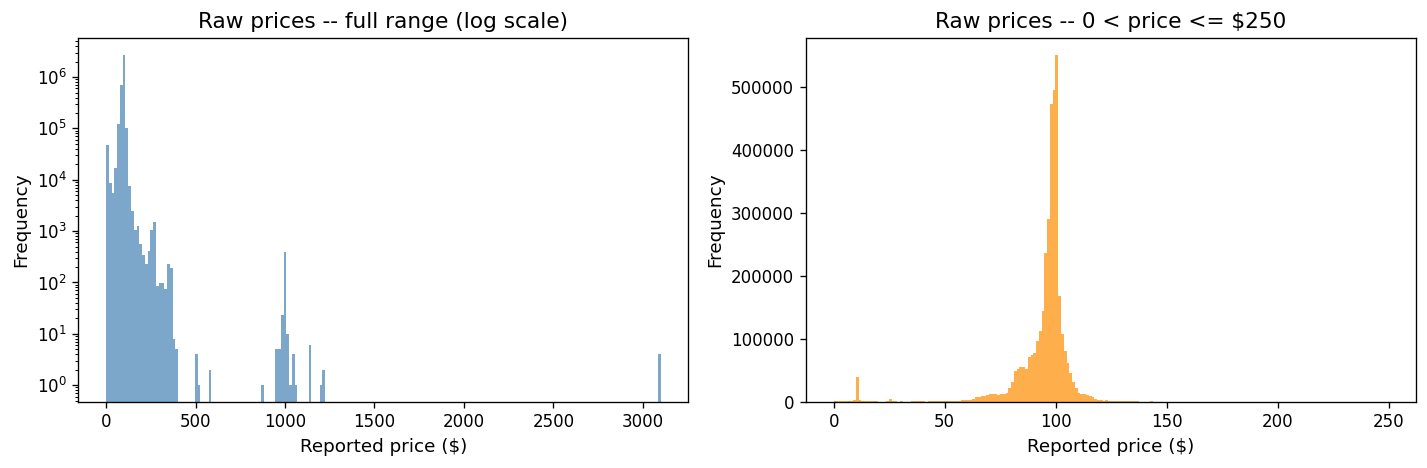

Prices <= 0:   0
Prices > 1000: 29
Null prices:   0


In [6]:
raw_prices = raw.select("rptd_pr").collect()["rptd_pr"].to_numpy()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(
    raw_prices[np.isfinite(raw_prices)],
    bins=200,
    color="steelblue",
    alpha=0.7,
    edgecolor="none",
)
axes[0].set_xlabel("Reported price ($)")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Raw prices -- full range (log scale)")
axes[0].set_yscale("log")

mask = (raw_prices > 0) & (raw_prices <= 250)
axes[1].hist(raw_prices[mask], bins=200, color="darkorange", alpha=0.7, edgecolor="none")
axes[1].set_xlabel("Reported price ($)")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Raw prices -- 0 < price <= $250")

fig.tight_layout()
plt.show()

print(f"Prices <= 0:   {(raw_prices <= 0).sum():,}")
print(f"Prices > 1000: {(raw_prices[np.isfinite(raw_prices)] > 1000).sum():,}")
print(f"Null prices:   {np.isnan(raw_prices).sum():,}")

### A single bond's intraday trades

To build intuition, let's look at a single well-traded bond across one day.
We plot every TRACE record colored by its status code.

In [7]:
top_cusips = (
    raw.filter(pl.col("trc_st") == "T")
    .group_by("cusip_id")
    .agg(pl.len().alias("n"))
    .sort("n", descending=True)
    .head(5)
    .collect()
)
print("Top 5 CUSIPs by original-trade count (Jan 2024):")
top_cusips

Top 5 CUSIPs by original-trade count (Jan 2024):


cusip_id,n
str,u32
"""95000U3B7""",16722
"""126650CX6""",5750
"""06051GFM6""",5477
"""718172CW7""",4992
"""20030NCT6""",4384


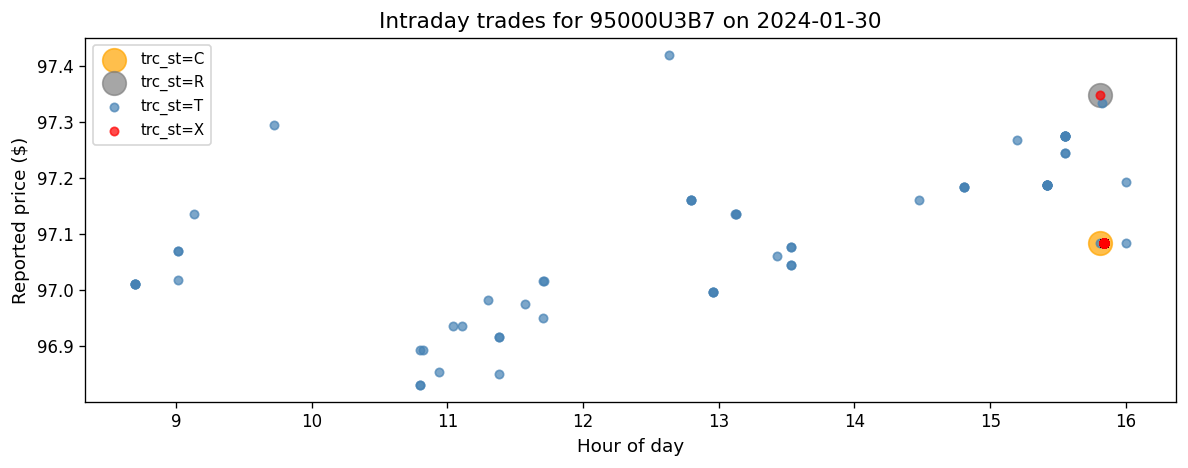

Total records: 10192
  trc_st=C: 1
  trc_st=R: 1
  trc_st=T: 5126
  trc_st=X: 5064


In [8]:
# Find a cusip-date pair that has multiple status codes (T, C, X, etc.)
# so the scatter plot illustrates the lifecycle records.
_cusip_date_mix = (
    raw.group_by("cusip_id", "trd_exctn_dt")
    .agg(
        pl.col("trc_st").n_unique().alias("n_status"),
        pl.len().alias("n_records"),
    )
    .filter(pl.col("n_status") >= 3)
    .sort("n_records", descending=True)
    .head(1)
    .collect()
)

# Fall back to the most-traded cusip on 2024-01-16 if no multi-status pair found
if len(_cusip_date_mix) > 0:
    example_cusip = _cusip_date_mix["cusip_id"][0]
    example_date = _cusip_date_mix["trd_exctn_dt"][0]
else:
    example_cusip = top_cusips["cusip_id"][0]
    example_date = None

intraday = (
    raw.filter(
        (pl.col("cusip_id") == example_cusip)
        & (
            (pl.col("trd_exctn_dt") == example_date)
            if example_date is not None
            else (pl.col("trd_exctn_dt") == pl.lit("2024-01-16").str.to_date())
        )
    )
    .sort("trd_exctn_tm")
    .collect()
)

# If the chosen date is empty, fall back to the first available date
if len(intraday) == 0:
    first_date = (
        raw.filter(pl.col("cusip_id") == example_cusip)
        .select(pl.col("trd_exctn_dt").min())
        .collect()
        .item()
    )
    intraday = (
        raw.filter(
            (pl.col("cusip_id") == example_cusip)
            & (pl.col("trd_exctn_dt") == first_date)
        )
        .sort("trd_exctn_tm")
        .collect()
    )

# Convert trd_exctn_tm to hours for plotting
tm_col = intraday["trd_exctn_tm"]
if tm_col.dtype in (pl.Int64, pl.UInt64, pl.Float64):
    times_hrs = tm_col.to_numpy().astype("float64") / 1e9 / 3600
elif tm_col.dtype == pl.Duration:
    times_hrs = tm_col.dt.total_seconds().to_numpy().astype("float64") / 3600
elif tm_col.dtype == pl.Time:
    times_hrs = (
        tm_col.dt.hour().cast(pl.Float64)
        + tm_col.dt.minute().cast(pl.Float64) / 60
        + tm_col.dt.second().cast(pl.Float64) / 3600
    ).to_numpy()
else:
    # String HH:MM:SS
    parts = tm_col.str.split(":")
    times_hrs = (
        parts.list.get(0).cast(pl.Float64)
        + parts.list.get(1).cast(pl.Float64) / 60
        + parts.list.get(2).cast(pl.Float64) / 3600
    ).to_numpy()

trade_date = intraday["trd_exctn_dt"][0]
prices = intraday["rptd_pr"].to_numpy()
statuses = intraday["trc_st"].to_list()

colors_map = {"T": "steelblue", "X": "red", "C": "orange", "W": "purple", "Y": "green"}

fig, ax = plt.subplots(figsize=(10, 4))
for status in sorted(set(statuses)):
    mask_s = np.array([s == status for s in statuses])
    size = 200 if status in ("C", "R") else 25
    ax.scatter(
        times_hrs[mask_s],
        prices[mask_s],
        label=f"trc_st={status}",
        alpha=0.7,
        s=size,
        color=colors_map.get(status, "gray"),
    )
ax.set_xlabel("Hour of day")
ax.set_ylabel("Reported price ($)")
ax.set_title(f"Intraday trades for {example_cusip} on {trade_date}")
ax.legend(fontsize=9)
fig.tight_layout()
plt.show()

print(f"Total records: {len(intraday)}")
for st in sorted(set(statuses)):
    print(f"  trc_st={st}: {statuses.count(st)}")

Cancellations (red) and corrections (orange) are **not independent trades**.
They reference prior records via `orig_msg_seq_nb` and must be matched and
removed or replaced. This is the job of the Dick-Nielsen procedure.

---
## 4. FISD Universe Filtering

Before cleaning trade data, we restrict to **standard US corporate bonds**
using the Mergent Fixed Income Securities Database (FISD). The universe is
built with these screens:

1. USD denominated only
2. Fixed-rate coupon (exclude variable)
3. Non-convertible
4. Non-asset-backed
5. Exclude government, municipal, MBS, ABS, and other non-corporate types
6. Valid coupon frequency
7. Complete accrual fields (offering_date, dated_date)
8. Principal amount = $1,000
9. Exclude equity-linked / index-linked bonds
10. Tenor >= 1 year

We then inner-join TRACE on `cusip_id` with the FISD universe, dropping all
non-matching bonds.

In [9]:
fisd = pl.scan_parquet(DATA_DIR / "fisd_universe.parquet")
n_fisd = fisd.select(pl.len()).collect().item()
print(f"FISD Universe: {n_fisd:,} bonds")

FISD Universe: 111,727 bonds


### Example bonds from the FISD universe

In [10]:
fisd.head(5).collect()

complete_cusip,issue_id,issue_name,issuer_id,foreign_currency,coupon_type,coupon,convertible,asset_backed,rule_144a,bond_type,private_placement,interest_frequency,dated_date,day_count_basis,offering_date,maturity,principal_amt,offering_amt,country_domicile,sic_code,tenor
str,f64,str,f64,str,str,f64,str,str,str,str,str,i64,date,str,date,date,f64,f64,str,str,f64
"""000361AA3""",1.0,"""NT""",3.0,"""N""","""F""",9.5,"""N""","""N""","""N""","""CDEB""","""N""",2,1989-11-01,"""30/360""",1989-10-24,2001-11-01,1000.0,65000.0,"""USA""","""3720""",12.021903
"""000361AB1""",2.0,"""NT""",3.0,"""N""","""F""",7.25,"""N""","""N""","""N""","""CDEB""","""N""",2,1993-10-15,"""30/360""",1993-10-12,2003-10-15,1000.0,50000.0,"""USA""","""3720""",10.006845
"""00077DAB5""",3.0,"""MTN""",40263.0,"""N""","""F""",4.15,"""N""","""N""","""N""","""CMTN""","""N""",2,1994-01-14,"""30/360""",1994-01-07,1996-01-12,1000.0,100000.0,"""USA""","""6029""",2.01232
"""00077DAF6""",4.0,"""SUB DEP NT SER B""",40263.0,"""N""","""F""",8.25,"""N""","""N""","""N""","""USBN""","""N""",2,1994-08-02,"""30/360""",1994-07-27,2009-08-01,1000.0,200000.0,"""USA""","""6029""",15.014374
"""00077TAA2""",5.0,"""SUB DEP NT SER B""",40263.0,"""N""","""F""",7.75,"""N""","""N""","""N""","""CDEB""","""N""",2,1993-05-15,"""30/360""",1993-05-20,2023-05-15,1000.0,250000.0,"""USA""","""6029""",29.984942


### Raw vs FISD-filtered comparison

In [11]:
fisd_filtered = pl.scan_parquet(
    DATA_DIR / "trace_enhanced_fisd" / "**/*.parquet",
    hive_partitioning=True,
).filter(pl.col("year") == 2024, pl.col("month") == 1)

n_fisd_filtered = fisd_filtered.select(pl.len()).collect().item()

n_cusips_raw = raw.select(pl.col("cusip_id").n_unique()).collect().item()
n_cusips_fisd = fisd_filtered.select(pl.col("cusip_id").n_unique()).collect().item()

print(f"{'':30s} {'Rows':>12s} {'Unique CUSIPs':>15s}")
print(f"{'Raw TRACE Enhanced (Jan 24)':30s} {n_raw:>12,} {n_cusips_raw:>15,}")
print(f"{'After FISD filter':30s} {n_fisd_filtered:>12,} {n_cusips_fisd:>15,}")
print(f"{'Dropped':30s} {n_raw - n_fisd_filtered:>12,} {n_cusips_raw - n_cusips_fisd:>15,}")
pct = 100 * (n_raw - n_fisd_filtered) / n_raw
print(f"\nFISD filter removes {pct:.1f}% of raw trade records.")

                                       Rows   Unique CUSIPs
Raw TRACE Enhanced (Jan 24)       3,768,457          29,998
After FISD filter                 2,792,786          11,940
Dropped                             975,671          18,058

FISD filter removes 25.9% of raw trade records.


The FISD filter removes trades in non-standard bonds (government, MBS, ABS,
municipals, convertibles, etc.) that are not the focus of corporate bond
research.

---
## 5. Stage 0: Dick-Nielsen Cleaning Pipeline

Stage 0 applies **11 sequential filters** to the FISD-filtered intraday data
and ends with daily aggregation. The implementation lives in
`src/stage0/clean_trace_local.py` (function `_apply_filter_chain`).

| # | Filter | Purpose |
|---|--------|---------|
| 1 | **Dick-Nielsen** | Match and remove cancellations, corrections, reversals; remove agency inter-dealer duplicates |
| 2 | **Decimal-shift corrector** | Fix prices that are 10x, 100x, 0.1x, or 0.01x off from neighboring trades |
| 3 | **Trading time** | Restrict to market hours (disabled by default) |
| 4 | **Trading calendar** | Remove trades on non-trading days (weekends, holidays per NYSE calendar) |
| 5 | **Price filter** | Remove trades with price <= 0 or > $1,000 |
| 6 | **Volume filter** | Remove trades with dollar volume < $10,000 |
| 7 | **Bounce-back filter** | Detect erroneous price spikes that revert within a few trades |
| 8 | **Yield-price consistency** | Remove rows where the yield field equals the price field (data entry error) |
| 9 | **Amount outstanding** | Remove trades with volume > 50% of offering amount |
| 10 | **Execution vs maturity** | Remove trades executed after the bond's maturity date |
| 11 | **Initial price error** | Flag extreme price jumps in the first few trades per CUSIP |

After all filters, intraday trades are **aggregated to one row per
(cusip_id, date)** with equal-weighted price (`prc_ew`), volume-weighted
price (`prc_vw`), first/last prices, trade count, and total volume.

### Stage 0 output: the daily panel

In [12]:
s0 = pl.scan_parquet(
    DATA_DIR / "stage0" / "enhanced" / "year=*/month=*/data.parquet",
    hive_partitioning=True,
)

s0_jan = s0.filter(pl.col("year") == 2024, pl.col("month") == 1)
n_s0 = s0_jan.select(pl.len()).collect().item()
s0_cols = s0.collect_schema().names()
print(f"Stage 0 Enhanced (Jan 2024) -- Rows: {n_s0:,} (one row per cusip-day)")
print(f"Columns ({len(s0_cols)}): {s0_cols}")

Stage 0 Enhanced (Jan 2024) -- Rows: 149,135 (one row per cusip-day)
Columns (23): ['cusip_id', 'trd_exctn_dt', 'prc_ew', 'prc_vw', 'prc_vw_par', 'prc_first', 'prc_last', 'prc_hi', 'prc_lo', 'trade_count', 'time_ew', 'time_last', 'qvolume', 'dvolume', 'prc_bid', 'bid_last', 'bid_time_ew', 'bid_time_last', 'prc_ask', 'bid_count', 'ask_count', 'year', 'month']


### Example rows

In [13]:
s0_jan.head(10).collect()

cusip_id,trd_exctn_dt,prc_ew,prc_vw,prc_vw_par,prc_first,prc_last,prc_hi,prc_lo,trade_count,time_ew,time_last,qvolume,dvolume,prc_bid,bid_last,bid_time_ew,bid_time_last,prc_ask,bid_count,ask_count,year,month
str,datetime[ms],f64,f64,f64,f64,f64,f64,f64,i64,f64,i32,f64,f64,f64,f64,f64,i32,f64,f64,f64,i64,i64
"""00037BAC6""",2024-01-16 00:00:00,89.9055,89.90575,89.90575,89.905,89.906,89.906,89.905,4,57610.0,57610,0.16,0.1438492,null,null,null,null,89.90575,null,2.0,2024,1
"""00037BAC6""",2024-01-24 00:00:00,89.658,89.658,89.658,89.658,89.658,89.658,89.658,1,43883.0,43883,1.0,0.89658,null,null,null,null,89.658,null,1.0,2024,1
"""00037BAC6""",2024-01-30 00:00:00,90.477,90.477,90.477,90.477,90.477,90.477,90.477,1,57628.0,57628,0.669,0.605291,90.477,90.477,57628.0,57628,null,1.0,0.0,2024,1
"""00037BAC6""",2024-01-31 00:00:00,91.183667,91.084617,91.084437,91.276,90.999,91.276,90.999,3,41617.333333,44742,4.338,3.951243,null,null,null,null,90.999,null,1.0,2024,1
"""00037BAF9""",2024-01-02 00:00:00,98.217,98.217,98.217,98.217,98.217,98.217,98.217,1,41319.0,41319,0.26,0.2553642,null,null,null,null,98.217,null,1.0,2024,1
"""00037BAF9""",2024-01-03 00:00:00,98.611,98.611,98.611,98.611,98.611,98.611,98.611,2,57612.0,57612,2.0,1.97222,null,null,null,null,98.611,null,1.0,2024,1
"""00037BAF9""",2024-01-24 00:00:00,97.731,97.731,97.731,97.731,97.731,97.731,97.731,1,51328.0,51328,0.075,0.073298,null,null,null,null,97.731,null,1.0,2024,1
"""00037BAF9""",2024-01-29 00:00:00,98.303,98.303,98.303,98.303,98.303,98.303,98.303,1,57635.0,57635,0.1,0.098303,98.303,98.303,57635.0,57635,null,1.0,0.0,2024,1
"""00037BAF9""",2024-01-30 00:00:00,98.14664,98.146641,98.14664,98.13883,98.15445,98.15445,98.13883,2,48722.0,48722,0.18,0.176664,null,null,null,null,null,null,null,2024,1


### Data reduction through the pipeline

The table below shows how row counts change at each stage.

In [14]:
raw_both = pl.scan_parquet(
    PULL_DIR / "trace_enhanced" / "**/*.parquet",
    hive_partitioning=True,
    missing_columns="insert",
).select(pl.len()).collect().item()

fisd_both = pl.scan_parquet(
    DATA_DIR / "trace_enhanced_fisd" / "**/*.parquet",
    hive_partitioning=True,
).select(pl.len()).collect().item()

s0_both = s0.select(pl.len()).collect().item()

summary = pl.DataFrame({
    "Stage": [
        "Raw TRACE Enhanced",
        "After FISD filter",
        "Stage 0 (daily panel)",
    ],
    "Rows": [raw_both, fisd_both, s0_both],
    "Granularity": [
        "intraday trade reports",
        "intraday trade reports",
        "one row per cusip-day",
    ],
})
summary

Stage,Rows,Granularity
str,i64,str
"""Raw TRACE Enhanced""",423792457,"""intraday trade reports"""
"""After FISD filter""",329061163,"""intraday trade reports"""
"""Stage 0 (daily panel)""",286454,"""one row per cusip-day"""


The dramatic reduction from millions of intraday records to the daily panel
reflects both (a) removal of erroneous/duplicate records and (b) daily
aggregation.

### Daily trade counts: raw vs cleaned

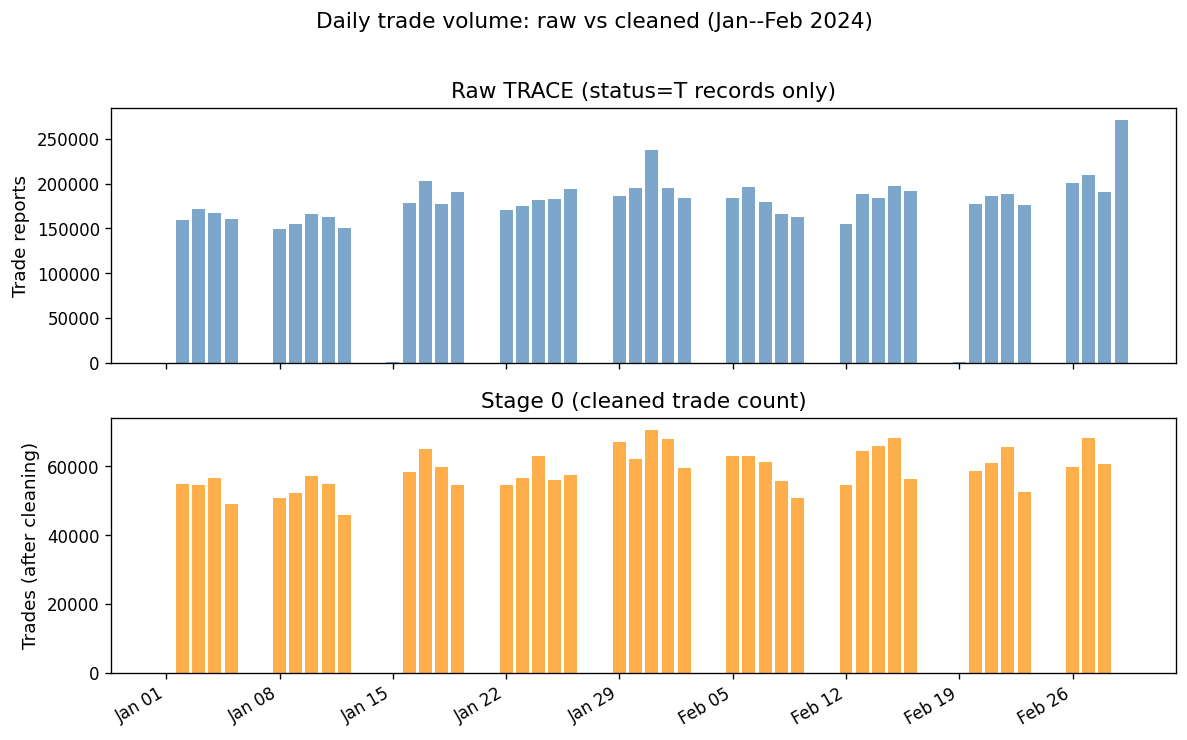

In [15]:
raw_daily = (
    pl.scan_parquet(
        PULL_DIR / "trace_enhanced" / "**/*.parquet",
        hive_partitioning=True,
        missing_columns="insert",
    )
    .filter(
        pl.col("trc_st") == "T",
        pl.col("year") == 2024,
        pl.col("month").is_in([1, 2]),
    )
    .group_by("trd_exctn_dt")
    .agg(pl.len().alias("n_trades"))
    .sort("trd_exctn_dt")
    .collect()
)

s0_daily = (
    s0.filter(pl.col("year") == 2024, pl.col("month").is_in([1, 2]))
    .group_by("trd_exctn_dt")
    .agg(pl.col("trade_count").sum().alias("n_trades"))
    .sort("trd_exctn_dt")
    .collect()
)

fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

raw_dates = raw_daily["trd_exctn_dt"].to_pandas()
s0_dates = s0_daily["trd_exctn_dt"].to_pandas()

axes[0].bar(
    raw_dates,
    raw_daily["n_trades"].to_list(),
    color="steelblue",
    alpha=0.7,
    width=0.8,
)
axes[0].set_ylabel("Trade reports")
axes[0].set_title("Raw TRACE (status=T records only)")

axes[1].bar(
    s0_dates,
    s0_daily["n_trades"].to_list(),
    color="darkorange",
    alpha=0.7,
    width=0.8,
)
axes[1].set_ylabel("Trades (after cleaning)")
axes[1].set_title("Stage 0 (cleaned trade count)")
for _ax in axes:
    _ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))
    _ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
plt.setp(axes[1].get_xticklabels(), rotation=30, ha="right")

fig.suptitle(
    "Daily trade volume: raw vs cleaned (Jan--Feb 2024)", fontsize=13, y=1.02
)
fig.tight_layout()
plt.show()

### Price distributions: raw vs cleaned

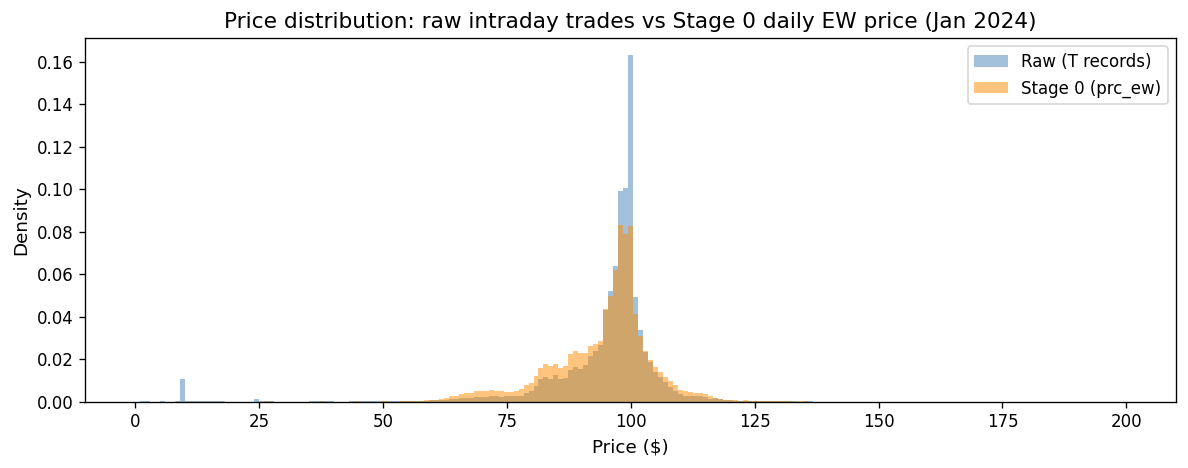

In [16]:
raw_pr = (
    pl.scan_parquet(
        PULL_DIR / "trace_enhanced" / "**/*.parquet",
        hive_partitioning=True,
        missing_columns="insert",
    )
    .filter(
        (pl.col("trc_st") == "T")
        & (pl.col("year") == 2024)
        & (pl.col("month") == 1)
    )
    .select("rptd_pr")
    .collect()["rptd_pr"]
    .to_numpy()
)

s0_pr = (
    s0_jan.select("prc_ew").collect()["prc_ew"].to_numpy()
)

fig, ax = plt.subplots(figsize=(10, 4))
bins = np.linspace(0, 200, 200)
ax.hist(
    raw_pr[(raw_pr > 0) & (raw_pr <= 200)],
    bins=bins,
    alpha=0.5,
    label="Raw (T records)",
    color="steelblue",
    density=True,
)
ax.hist(
    s0_pr[(s0_pr > 0) & (s0_pr <= 200)],
    bins=bins,
    alpha=0.5,
    label="Stage 0 (prc_ew)",
    color="darkorange",
    density=True,
)
ax.set_xlabel("Price ($)")
ax.set_ylabel("Density")
ax.set_title("Price distribution: raw intraday trades vs Stage 0 daily EW price (Jan 2024)")
ax.legend()
fig.tight_layout()
plt.show()

The cleaned distribution is tighter, with extreme tails removed. Daily
aggregation (averaging across trades) further reduces noise.

### Equal-weighted vs volume-weighted prices

The Stage 0 panel provides both `prc_ew` (equal-weighted average across
all intraday trades) and `prc_vw` (volume-weighted). For research,
**volume-weighted prices down-weight small "noise" trades**, providing
a better estimate of the bond's true price.

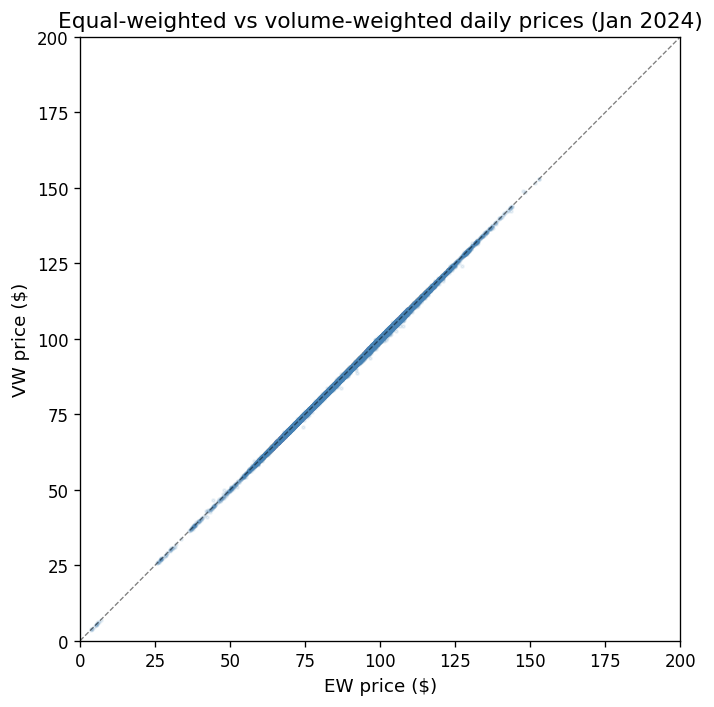

Mean |EW - VW| difference:   $0.0629
Median |EW - VW| difference: $0.0220
95th pctile |EW - VW|:       $0.2612


In [17]:
s0_prices = (
    s0_jan.select("prc_ew", "prc_vw").collect()
)

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(
    s0_prices["prc_ew"].to_numpy(),
    s0_prices["prc_vw"].to_numpy(),
    alpha=0.1,
    s=3,
    color="steelblue",
)
lims = [0, 200]
ax.plot(lims, lims, "k--", linewidth=0.8, alpha=0.5)
ax.set_xlabel("EW price ($)")
ax.set_ylabel("VW price ($)")
ax.set_title("Equal-weighted vs volume-weighted daily prices (Jan 2024)")
ax.set_xlim(lims)
ax.set_ylim(lims)
fig.tight_layout()
plt.show()

diff = np.abs(s0_prices["prc_ew"].to_numpy() - s0_prices["prc_vw"].to_numpy())
print(f"Mean |EW - VW| difference:   ${np.nanmean(diff):.4f}")
print(f"Median |EW - VW| difference: ${np.nanmedian(diff):.4f}")
print(f"95th pctile |EW - VW|:       ${np.nanpercentile(diff, 95):.4f}")

### Market microstructure noise in context

Most points lie on the 45-degree line, but the divergences---where
small trades transact at systematically different prices than large
trades---are precisely the **market microstructure noise (MMN)** that
Dickerson, Robotti, and Rossetti (2024) warn about.

Key implications from DRR (2024):

- Even after cleaning, daily prices contain MMN because individual trades
  include bid-ask bounce and dealer markups.
- The EW price gives equal weight to a $10K retail trade and a $5M
  institutional block---yet these trades occur at systematically different
  prices.
- The VW price partially mitigates this, but does not fully remove MMN.
- Using noisy prices as signals for portfolio sorts creates **spurious
  predictability**. For example, short-term reversal premia of 0.90%/month
  vanish after MMN correction.
- Volume-weighted prices (`prc_vw`) should be preferred over `prc_ew`
  when computing returns for research.

---
## 6. Stage 1: Enrichment

Stage 1 takes the clean daily panel from Stage 0 and enriches it with
bond analytics and reference data:

**Analytics (computed via QuantLib):**
- Accrued interest (to convert between clean and dirty prices)
- Yield to maturity (YTM)
- Modified duration and Macaulay duration
- Convexity
- Credit spread (bond yield minus duration-matched Liu-Wu Treasury
  zero-coupon yield)

**Merged reference data:**
- FISD bond characteristics (coupon, maturity, offering amount, callable flag)
- Credit ratings from Moody's and S&P (as-of, forward-filled)
- Fama-French 17/30 industry classification (via SIC codes)
- Equity identifiers (PERMNO, PERMCO, GVKEY) via the OBAP bond-firm linker

In [18]:
import glob

s1_files = sorted(glob.glob(str(DATA_DIR / "stage1" / "stage1_*.parquet")))
s1_path = s1_files[-1]  # most recent
s1 = pl.scan_parquet(s1_path)
n_s1 = s1.select(pl.len()).collect().item()
cols_s1 = s1.collect_schema().names()
print(f"Stage 1 ({Path(s1_path).name}) -- Rows: {n_s1:,}  |  Columns: {len(cols_s1)}")
print(f"Columns: {cols_s1}")

Stage 1 (stage1_20260223.parquet) -- Rows: 333,901  |  Columns: 43
Columns: ['cusip_id', 'permno', 'permco', 'gvkey', 'trd_exctn_dt', 'pr', 'prfull', 'acclast', 'accpmt', 'accall', 'ytm', 'mod_dur', 'mac_dur', 'convexity', 'bond_maturity', 'credit_spread', 'prc_ew', 'prc_vw_par', 'prc_first', 'prc_last', 'prc_hi', 'prc_lo', 'trade_count', 'time_ew', 'time_last', 'qvolume', 'dvolume', 'prc_bid', 'bid_last', 'bid_time_ew', 'bid_time_last', 'prc_ask', 'bid_count', 'ask_count', 'db_type', 'ff17num', 'ff30num', 'bond_age', 'bond_amt_outstanding', 'sp_rating', 'mdy_rating', 'spc_rating', 'mdc_rating']


### Example rows

In [19]:
s1.head(10).collect()

cusip_id,permno,permco,gvkey,trd_exctn_dt,pr,prfull,acclast,accpmt,accall,ytm,mod_dur,mac_dur,convexity,bond_maturity,credit_spread,prc_ew,prc_vw_par,prc_first,prc_last,prc_hi,prc_lo,trade_count,time_ew,time_last,qvolume,dvolume,prc_bid,bid_last,bid_time_ew,bid_time_last,prc_ask,bid_count,ask_count,db_type,ff17num,ff30num,bond_age,bond_amt_outstanding,sp_rating,mdy_rating,spc_rating,mdc_rating
cat,i32,i32,i32,datetime[ns],f32,f32,f32,f32,f32,f64,f32,f32,f32,f32,f64,f32,f32,f32,f32,f32,f32,i16,f32,i32,f32,f32,f32,f32,f32,f32,f32,i16,i16,i8,i8,i8,f32,i64,i8,i8,i8,i8
"""00033GAA3""",null,null,null,2024-01-12 00:00:00,99.644699,99.64473,0.0,0.0,0.0,0.084359,4.018,4.187,19.893,5.01,0.046275,99.662743,99.64463,99.75,99.5,100.080002,99.5,47,32683.873047,55470,43.099998,42.946835,99.606499,99.5,33551.53125,55470.0,99.813789,17,5,3,16,29,0.002738,525000,14,15,14,15
"""00033GAA3""",null,null,null,2024-01-16 00:00:00,98.920601,98.920624,0.0,0.0,0.0,0.086234,4.008,4.181,19.813,4.999,0.047138,98.936501,98.919998,99.5,98.949997,99.5,98.625,20,45762.851562,55865,17.25,17.0637,98.970909,98.6875,39102.855469,52321.0,99.028244,7,6,3,16,29,0.013689,525000,14,15,14,15
"""00033GAA3""",null,null,null,2024-01-17 00:00:00,96.936501,96.936493,0.0,0.0,0.0,0.091364,3.986,4.168,19.632999,4.997,0.051367,96.930786,96.930786,98.030998,96.0,98.030998,96.0,14,51371.070312,63216,14.0,13.57031,97.00193,96.75,49492.5,53847.0,96.787689,4,9,3,16,29,0.016427,525000,14,15,14,15
"""00033GAA3""",null,null,null,2024-01-18 00:00:00,97.560303,97.56031,0.0,0.0,0.0,0.089939,3.983,4.163,19.608999,4.994,0.049759,97.559998,97.559998,97.625,97.25,97.75,97.25,5,46109.199219,54864,5.0,4.878,97.45858,97.25,46403.332031,54864.0,97.712517,3,2,3,16,29,0.019165,525000,14,15,14,15
"""00033GAA3""",null,null,null,2024-01-19 00:00:00,97.666901,97.690155,0.023264,0.0,0.023264,0.089667,3.982,4.16,19.594999,4.991,0.04948,97.800003,97.666664,97.599998,98.0,98.0,97.599998,2,53709.0,54910,1.2,1.172,null,null,null,null,97.666893,null,2,3,16,29,0.021903,525000,14,15,14,15
"""00033GAA3""",null,null,null,2024-01-22 00:00:00,97.141998,97.188507,0.046528,0.0,0.046528,0.091023,3.974,4.155,19.531,4.983,0.051037,97.141846,97.141846,97.195,97.5,97.5,97.0,19,53547.632812,59996,19.0,18.456949,97.123344,97.375,53735.855469,59911.0,97.267708,7,4,3,16,29,0.030116,525000,14,15,14,15
"""00033GAA3""",null,null,null,2024-01-23 00:00:00,96.408501,96.478279,0.069792,0.0,0.069792,0.092933,3.964,4.148,19.450001,4.98,0.052799,96.372002,96.408134,96.75,96.25,96.75,96.223999,7,53864.144531,60691,5.5,5.302447,96.402405,96.25,54821.75,60691.0,96.375,4,1,3,16,29,0.032854,525000,14,15,14,15
"""00033GAA3""",null,null,null,2024-01-24 00:00:00,95.909401,96.002426,0.093056,0.0,0.093056,0.094246,3.957,4.143,19.388,4.977,0.05366,95.783333,95.907265,96.808998,94.882004,96.808998,94.859001,6,44907.5,55726,3.6,3.452662,95.673523,94.859001,49877.0,55726.0,96.169693,2,3,3,16,29,0.035592,525000,14,15,14,15
"""00033GAA3""",null,null,null,2024-01-25 00:00:00,95.077301,95.240166,0.162847,0.0,0.162847,0.096461,3.94,4.131,19.254999,4.975,0.056679,95.077003,95.077003,95.25,94.903999,95.25,94.903999,2,40048.5,47720,2.0,1.90154,95.25,95.25,32377.0,32377.0,null,1,0,3,16,29,0.03833,525000,14,15,14,15


### Credit spread distribution

The credit spread is the yield premium a corporate bond pays over a
duration-matched Treasury zero-coupon yield. It reflects credit risk,
liquidity risk, and other bond-specific factors.

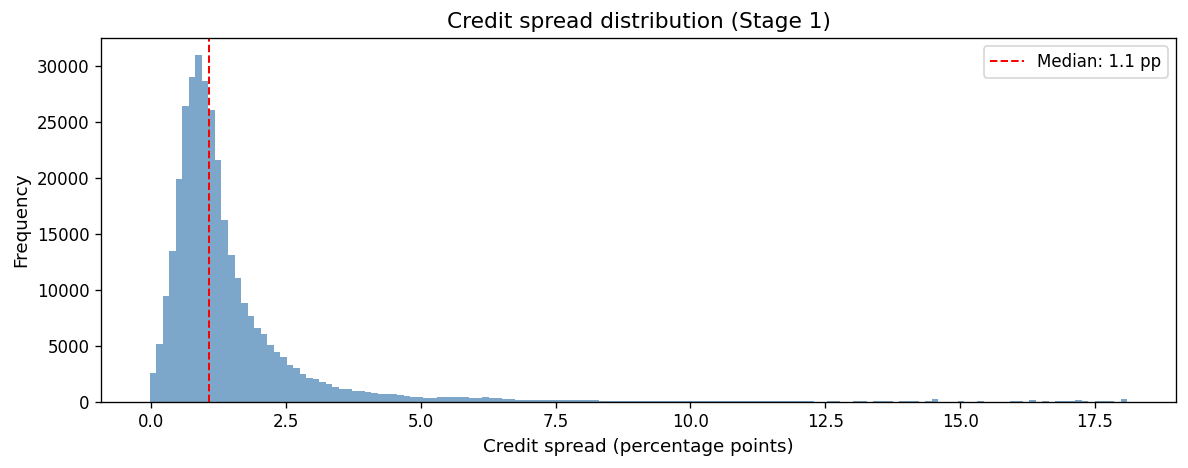

In [20]:
cs = (
    s1.filter(
        pl.col("credit_spread").is_not_null()
        & (pl.col("credit_spread") > -0.05)
        & (pl.col("credit_spread") < 0.25)
    )
    .select("credit_spread")
    .collect()["credit_spread"]
    .to_numpy()
)

fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(cs * 100, bins=150, color="steelblue", alpha=0.7, edgecolor="none")
median_cs = np.median(cs) * 100
ax.axvline(
    median_cs,
    color="red",
    linestyle="--",
    linewidth=1.2,
    label=f"Median: {median_cs:.1f} pp",
)
ax.set_xlabel("Credit spread (percentage points)")
ax.set_ylabel("Frequency")
ax.set_title("Credit spread distribution (Stage 1)")
ax.legend()
fig.tight_layout()
plt.show()

### Modified duration by credit rating

Investment-grade bonds (AAA through BBB) tend to have longer duration
because they carry lower default risk and can issue at longer maturities.
High-yield bonds (BB and below) tend to have shorter duration.

/var/folders/l3/tj6vb0ld2ys1h939jz0qrfrh0000gn/T/ipykernel_93385/3343011909.py:41: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_valid, labels=order_valid, patch_artist=True, showfliers=False)


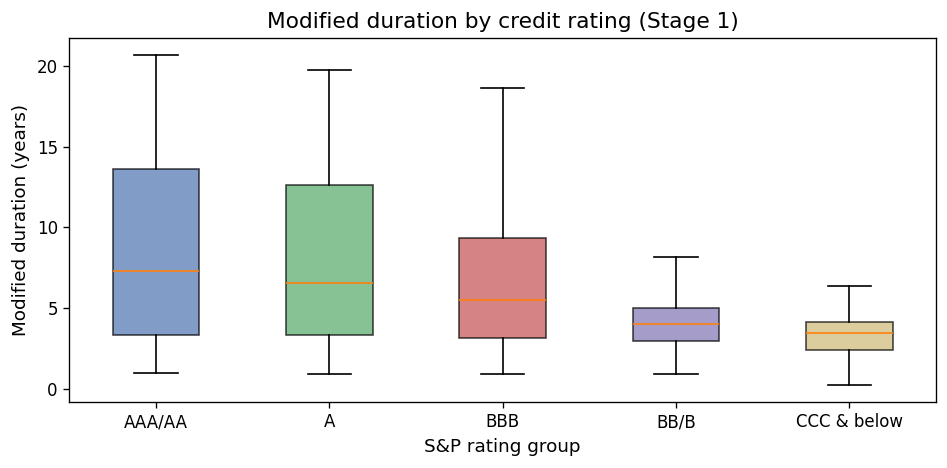

In [21]:
s1_dur = (
    s1.filter(
        pl.col("mod_dur").is_not_null()
        & pl.col("sp_rating").is_not_null()
        & (pl.col("mod_dur") > 0)
        & (pl.col("mod_dur") < 30)
        & (pl.col("sp_rating") > 0)
    )
    .select("mod_dur", "sp_rating")
    .collect()
)


def _rating_bucket(r):
    if r <= 3:
        return "AAA/AA"
    elif r <= 6:
        return "A"
    elif r <= 10:
        return "BBB"
    elif r <= 16:
        return "BB/B"
    else:
        return "CCC & below"


s1_dur_pd = s1_dur.to_pandas()
s1_dur_pd["rating_group"] = s1_dur_pd["sp_rating"].apply(_rating_bucket)

order = ["AAA/AA", "A", "BBB", "BB/B", "CCC & below"]
data_by_group = [
    s1_dur_pd.loc[s1_dur_pd["rating_group"] == g, "mod_dur"].values
    for g in order
]
# Only keep groups with data
valid = [(g, d) for g, d in zip(order, data_by_group) if len(d) > 0]
order_valid = [g for g, _ in valid]
data_valid = [d for _, d in valid]

fig, ax = plt.subplots(figsize=(8, 4))
bp = ax.boxplot(data_valid, labels=order_valid, patch_artist=True, showfliers=False)
box_colors = ["#4c72b0", "#55a868", "#c44e52", "#8172b2", "#ccb974"]
for i, patch in enumerate(bp["boxes"]):
    patch.set_facecolor(box_colors[i % len(box_colors)])
    patch.set_alpha(0.7)
ax.set_xlabel("S&P rating group")
ax.set_ylabel("Modified duration (years)")
ax.set_title("Modified duration by credit rating (Stage 1)")
fig.tight_layout()
plt.show()

### Bond age vs time-to-maturity

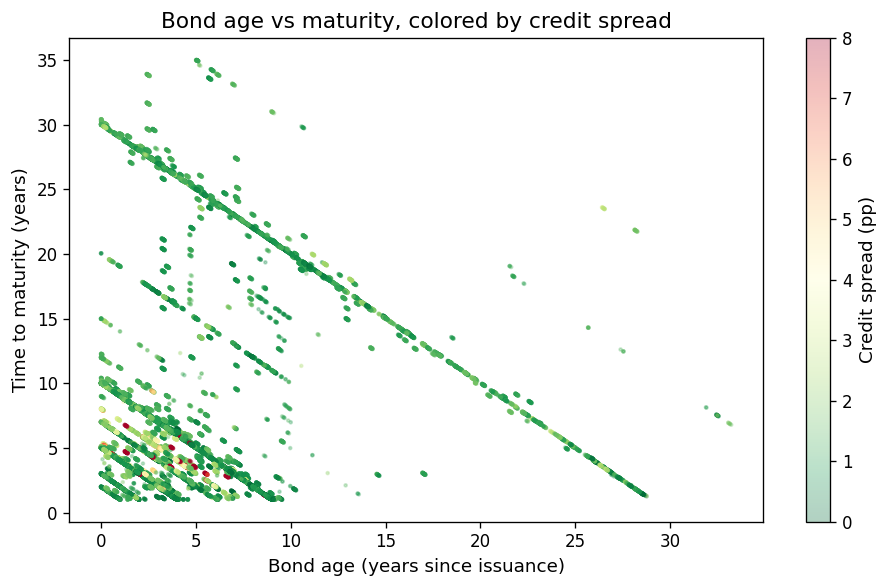

In [22]:
s1_scatter = (
    s1.filter(
        pl.col("bond_maturity").is_not_null()
        & pl.col("bond_age").is_not_null()
        & pl.col("credit_spread").is_not_null()
        & (pl.col("credit_spread") > -0.02)
        & (pl.col("credit_spread") < 0.20)
        & (pl.col("bond_maturity") > 0)
        & (pl.col("bond_maturity") < 35)
    )
    .select("bond_age", "bond_maturity", "credit_spread")
    .head(50_000)
    .collect()
)

fig, ax = plt.subplots(figsize=(8, 5))
sc = ax.scatter(
    s1_scatter["bond_age"].to_numpy(),
    s1_scatter["bond_maturity"].to_numpy(),
    c=s1_scatter["credit_spread"].to_numpy() * 100,
    s=3,
    alpha=0.3,
    cmap="RdYlGn_r",
    vmin=0,
    vmax=8,
)
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label("Credit spread (pp)")
ax.set_xlabel("Bond age (years since issuance)")
ax.set_ylabel("Time to maturity (years)")
ax.set_title("Bond age vs maturity, colored by credit spread")
fig.tight_layout()
plt.show()

---
## 7. Takeaways and Best Practices

1. **Always clean TRACE data before computing returns.** Raw data contains
   cancellations, corrections, reversals, decimal-shift errors, and
   bounce-back errors. Using uncleaned data biases return estimates.

2. **Use the FISD universe to restrict to standard US corporate bonds.**
   Mixing in government, muni, ABS, or MBS trades will contaminate your
   sample.

3. **Prefer volume-weighted prices** (`prc_vw`) over equal-weighted
   (`prc_ew`) when computing returns. EW prices over-weight small, noisy
   trades.

4. **Be aware of market microstructure noise.** Even after cleaning,
   daily prices contain bid-ask bounce and dealer markup noise
   (Dickerson, Robotti, and Rossetti, 2024). Price-based signals
   (e.g., short-term reversal) may be spuriously profitable.

5. **Avoid ex-post filtering.** Do not condition your bond sample on
   future price availability or forward-looking criteria. Use only
   ex-ante filters with information available at portfolio formation
   (Dickerson, Robotti, and Rossetti, 2024, 2026).

6. **Validate against known benchmarks.** Compare your output to the
   Open Bond Asset Pricing (OBAP) database for duration, convexity,
   and credit spread validation.

---
## References

- Dick-Nielsen, J. (2009). Liquidity biases in TRACE. *Journal of Fixed
  Income*, 19(2), 43--55.
- Dick-Nielsen, J. (2014). How to clean enhanced TRACE data. Working paper.
- Dickerson, A., Robotti, C., and Rossetti, G. (2024). Common pitfalls in
  the evaluation of corporate bond strategies. Available at SSRN:
  [https://ssrn.com/abstract=4575879](https://ssrn.com/abstract=4575879).
- Dickerson, A., Robotti, C., and Rossetti, G. (2026). The Corporate Bond
  Factor Replication Crisis.